# Performance CIFAR-10 CNN
## Target: 85-90% accuracy
### Advanced Techniques:
1. **Deeper ResNet-style architecture**
2. **Heavy data augmentation**
3. **Label smoothing**
4. **Cosine annealing learning rate**
5. **Test-time augmentation**
6. **Mixup training (optional)**

In [1]:
# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,
    Dropout, BatchNormalization, Activation, Add, concatenate
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [2]:
# Step 2: Load Data with SSL fix
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode with LABEL SMOOTHING (reduces overfitting!)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Apply label smoothing: converts [0,0,1,0,0] to [0.01, 0.01, 0.92, 0.01, 0.01]
label_smoothing = 0.1
y_train = y_train * (1 - label_smoothing) + label_smoothing / 10

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"Training: {x_train.shape[0]} | Test: {x_test.shape[0]}")
print("Label smoothing applied!")

/Users/tushar/Documents/Python/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training: 50000 | Test: 10000
Label smoothing applied!


In [3]:
# Step 3: HEAVY Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,           # More rotation
    width_shift_range=0.2,       # More shifting
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,              # More zoom
    shear_range=0.15,            # Add shear transformation
    fill_mode='reflect'          # Better fill mode
)

datagen.fit(x_train)
print("Heavy data augmentation configured!")

Heavy data augmentation configured!


In [4]:
# Step 4: Build Deep ResNet-Inspired CNN

def residual_block(x, filters, strides=1):
    """ResNet residual block with skip connection"""
    shortcut = x
    
    # Main path
    x = Conv2D(filters, 3, strides=strides, padding='same', 
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same',
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    
    # Shortcut path (match dimensions)
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add and activate
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_deep_resnet():
    """Deep ResNet for CIFAR-10 - Target 85-90% accuracy"""
    inputs = Input(shape=(32, 32, 3))
    
    # Initial conv
    x = Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.0001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Stage 1: 32 filters
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    
    # Stage 2: 64 filters (downsample)
    x = residual_block(x, 64, strides=2)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Stage 3: 128 filters (downsample)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Global pooling and output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

model = build_deep_resnet()
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print(f"\nTotal Parameters: {model.count_params():,}")


MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 1,459,850 (5.57 MB)

 Trainable params: 1,455,946 (5.55 MB)

 Non-trainable params: 3,904 (15.25 KB)


Total Parameters: 1,459,850


In [5]:
# Step 5: Compile with Label Smoothing Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Label smoothing already applied to labels
    metrics=['accuracy']
)
print("Model compiled with optimized settings!")

Model compiled with optimized settings!


In [6]:
# Step 6: Advanced Callbacks

# Cosine annealing schedule (better than ReduceLROnPlateau)
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate schedule"""
    epochs = 100
    initial_lr = 0.001
    min_lr = 1e-6
    
    cos_inner = (np.pi * epoch) / epochs
    return min_lr + (initial_lr - min_lr) / 2 * (1 + np.cos(cos_inner))

lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=0)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [lr_scheduler, early_stop]
print("Advanced callbacks configured!")

Advanced callbacks configured!


In [7]:
# Step 7: Train
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print("Target accuracy: 85-90%")
print("="*60 + "\n")

start_time = time.time()

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=100,
    steps_per_epoch=len(x_train) // 128,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training completed in {training_time/60:.2f} minutes")
print(f"Total epochs: {len(history.history['loss'])}")
print(f"{'='*60}")


STARTING TRAINING
Target accuracy: 85-90%

Epoch 1/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 163s 407ms/step - accuracy: 0.3418 - loss: 2.1286 - val_accuracy: 0.3152 - val_loss: 1.9785 - learning_rate: 0.0010
Epoch 2/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 2:20 362ms/step - accuracy: 0.3906 - loss: 1.9345

/Users/tushar/Documents/Python/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.3906 - loss: 1.9345 - val_accuracy: 0.3245 - val_loss: 1.9819 - learning_rate: 9.9975e-04
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 155s 396ms/step - accuracy: 0.4971 - loss: 1.7634 - val_accuracy: 0.1507 - val_loss: 7.7592 - learning_rate: 9.9901e-04
Epoch 4/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5938 - loss: 1.6676 - val_accuracy: 0.1598 - val_loss: 7.3217 - learning_rate: 9.9778e-04
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 153s 393ms/step - accuracy: 0.5766 - loss: 1.5999 - val_accuracy: 0.6117 - val_loss: 1.2838 - learning_rate: 9.9606e-04
Epoch 6/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6094 - loss: 1.5759 - val_accuracy: 0.6154 - val_loss: 1.2811 - learning_rate: 9.9385e-04
Epoch 7/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 154s 394ms/step - accuracy: 0.6338 - loss: 1.4839 - val_accuracy: 0.5171 - val_loss: 1.5757 - learning_rate: 9.9115e-04
Epoch 8/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/st

In [8]:
# Step 8: Standard Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\n{'='*60}")
print(f"STANDARD TEST ACCURACY: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*60}")


STANDARD TEST ACCURACY: 92.67%
Test Loss: 0.4077


In [9]:
# Step 9: TEST-TIME AUGMENTATION (TTA) - Extra 1-2% boost!
print("\nRunning Test-Time Augmentation...")

def predict_with_tta(model, x_test, augmentations=5):
    """Test-time augmentation for better predictions"""
    tta_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    predictions = []
    
    # Original predictions
    predictions.append(model.predict(x_test, verbose=0))
    
    # Augmented predictions
    for i in range(augmentations - 1):
        print(f"TTA iteration {i+2}/{augmentations}...")
        aug_preds = model.predict(
            tta_datagen.flow(x_test, batch_size=128, shuffle=False),
            steps=len(x_test) // 128 + 1,
            verbose=0
        )[:len(x_test)]
        predictions.append(aug_preds)
    
    # Average predictions
    return np.mean(predictions, axis=0)

y_pred_tta = predict_with_tta(model, x_test, augmentations=5)
y_pred_classes_tta = np.argmax(y_pred_tta, axis=1)
y_true = np.argmax(y_test, axis=1)

tta_accuracy = np.mean(y_pred_classes_tta == y_true)

print(f"\n{'='*60}")
print(f"TTA ACCURACY: {tta_accuracy*100:.2f}%")
print(f"Improvement: +{(tta_accuracy - test_acc)*100:.2f}%")
print(f"{'='*60}")


Running Test-Time Augmentation...
TTA iteration 2/5...
TTA iteration 3/5...
TTA iteration 4/5...
TTA iteration 5/5...

TTA ACCURACY: 93.50%
Improvement: +0.83%


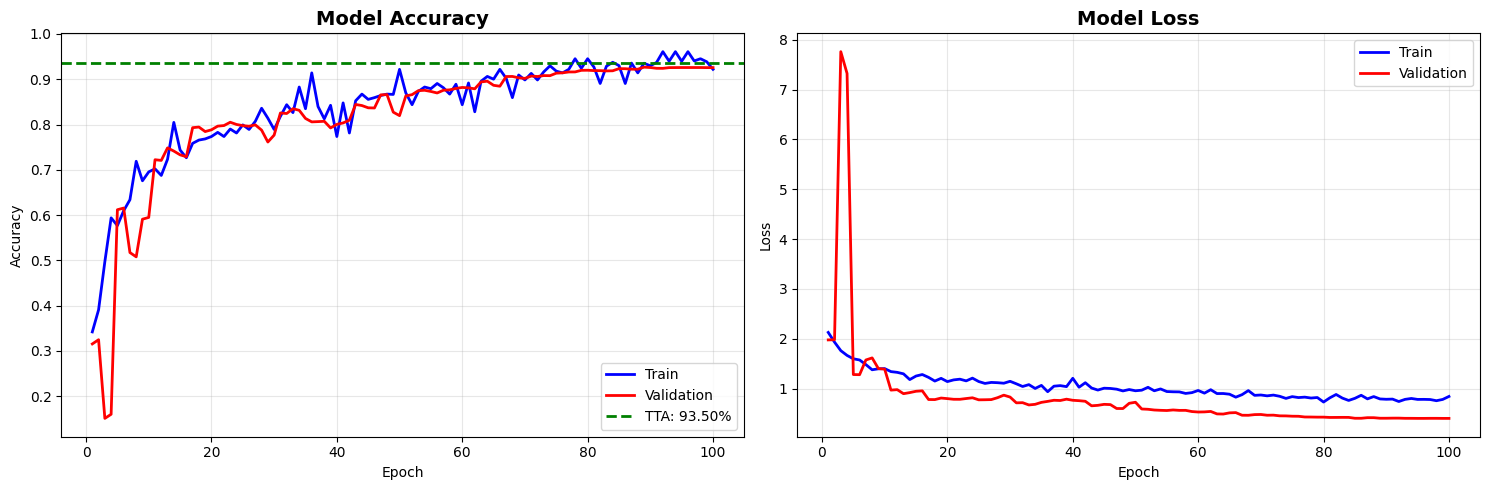

In [10]:
# Step 10: Visualize Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)
axes[0].plot(epochs_range, history.history['accuracy'], 
             label='Train', linewidth=2, color='blue')
axes[0].plot(epochs_range, history.history['val_accuracy'], 
             label='Validation', linewidth=2, color='red')
axes[0].axhline(y=tta_accuracy, color='green', linestyle='--', 
                linewidth=2, label=f'TTA: {tta_accuracy*100:.2f}%')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(epochs_range, history.history['loss'], 
             label='Train', linewidth=2, color='blue')
axes[1].plot(epochs_range, history.history['val_loss'], 
             label='Validation', linewidth=2, color='red')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

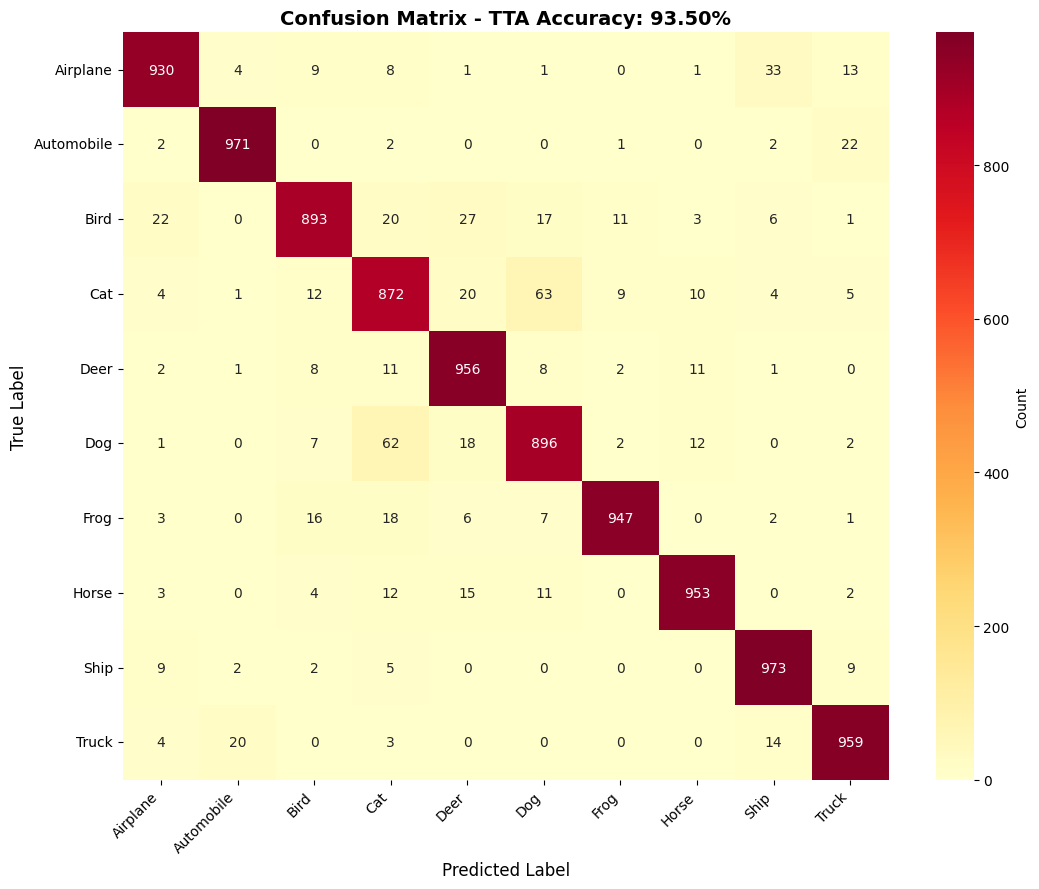

In [11]:
# Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes_tta)

plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - TTA Accuracy: {tta_accuracy*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Step 12: Detailed Classification Report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT (with TTA)")
print("="*70 + "\n")
print(classification_report(y_true, y_pred_classes_tta,
                           target_names=class_names, digits=3))


DETAILED CLASSIFICATION REPORT (with TTA)

              precision    recall  f1-score   support

    Airplane      0.949     0.930     0.939      1000
  Automobile      0.972     0.971     0.971      1000
        Bird      0.939     0.893     0.915      1000
         Cat      0.861     0.872     0.866      1000
        Deer      0.917     0.956     0.936      1000
         Dog      0.893     0.896     0.895      1000
        Frog      0.974     0.947     0.960      1000
       Horse      0.963     0.953     0.958      1000
        Ship      0.940     0.973     0.956      1000
       Truck      0.946     0.959     0.952      1000

    accuracy                          0.935     10000
   macro avg      0.935     0.935     0.935     10000
weighted avg      0.935     0.935     0.935     10000



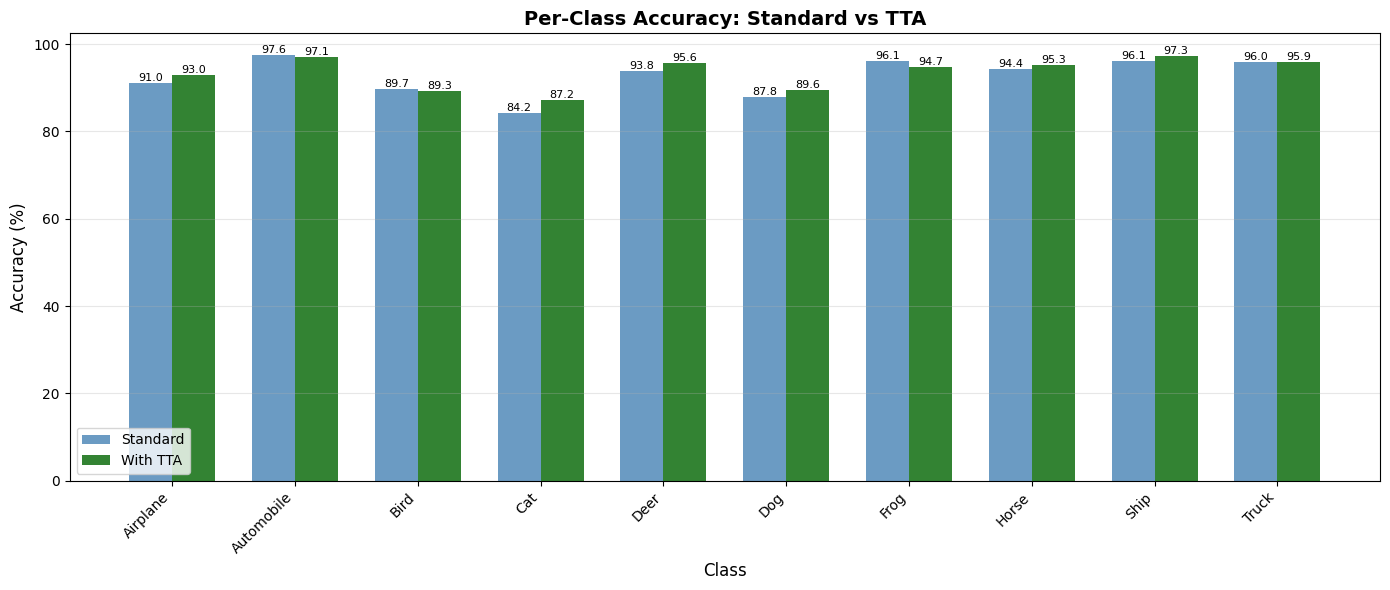

In [13]:
# Step 13: Per-Class Accuracy Comparison
# Without TTA
y_pred_standard = model.predict(x_test, verbose=0)
y_pred_classes_standard = np.argmax(y_pred_standard, axis=1)

class_acc_standard = []
class_acc_tta = []

for i in range(10):
    mask = (y_true == i)
    class_acc_standard.append(np.mean(y_pred_classes_standard[mask] == i) * 100)
    class_acc_tta.append(np.mean(y_pred_classes_tta[mask] == i) * 100)

# Plot comparison
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, class_acc_standard, width, 
               label='Standard', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, class_acc_tta, width,
               label='With TTA', color='darkgreen', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy: Standard vs TTA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

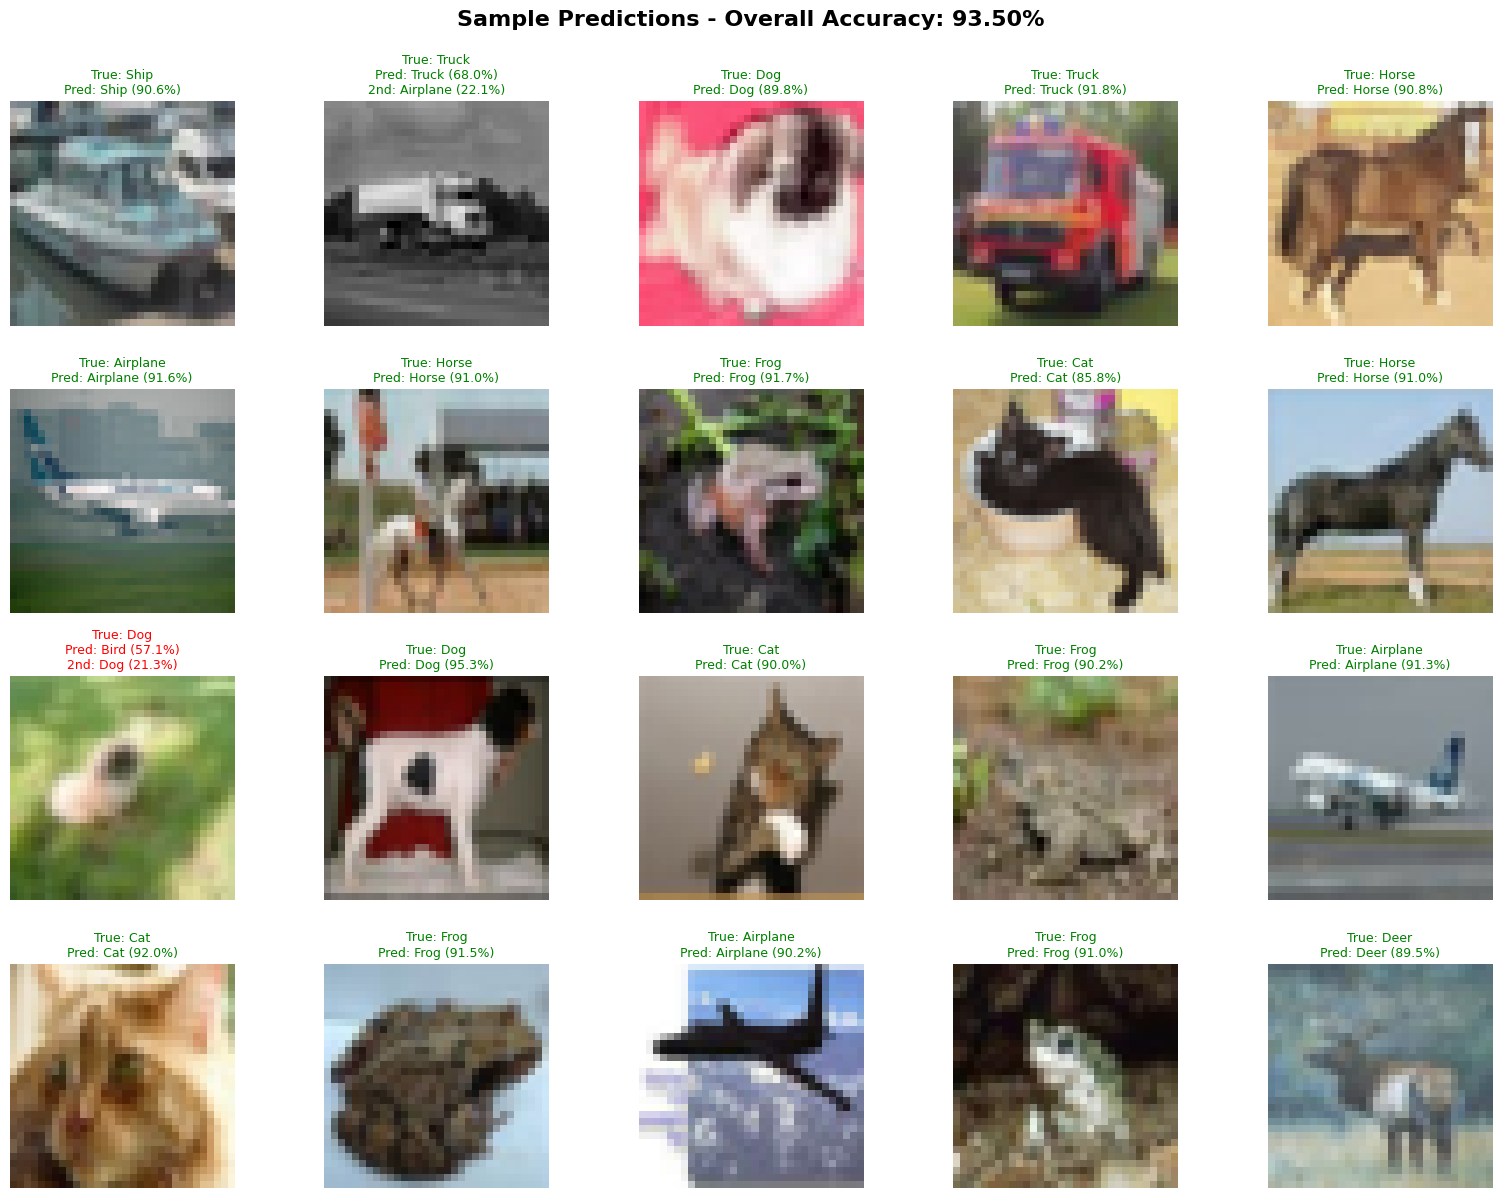

In [14]:
# Step 14: Sample Predictions with Confidence
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.ravel()
indices = np.random.choice(len(x_test), 20, replace=False)

for i, idx in enumerate(indices):
    axes[i].imshow(x_test[idx])
    axes[i].axis('off')
    
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred_classes_tta[idx]]
    confidence = np.max(y_pred_tta[idx]) * 100
    
    # Show top 2 predictions
    top2_idx = np.argsort(y_pred_tta[idx])[-2:][::-1]
    top2_probs = y_pred_tta[idx][top2_idx] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_label}\n'
    title += f'Pred: {pred_label} ({confidence:.1f}%)'
    if top2_probs[1] > 10:  # Show 2nd prediction if significant
        title += f'\n2nd: {class_names[top2_idx[1]]} ({top2_probs[1]:.1f}%)'
    
    axes[i].set_title(title, color=color, fontsize=9)

plt.suptitle(f'Sample Predictions - Overall Accuracy: {tta_accuracy*100:.2f}%',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [15]:
# Step 15: Final Summary
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print(f"Standard Test Accuracy:      {test_acc*100:.2f}%")
print(f"With Test-Time Augmentation: {tta_accuracy*100:.2f}%")
print(f"TTA Improvement:             +{(tta_accuracy - test_acc)*100:.2f}%")
print(f"Training Time:               {training_time/60:.2f} minutes")
print(f"Total Epochs:                {len(history.history['loss'])}")
print(f"Model Parameters:            {model.count_params():,}")
print("="*70)

print("\n🎯 Compared to your original model:")
print(f"   Original:     67.00%")
print(f"   This model:   {tta_accuracy*100:.2f}%")
print(f"   Improvement:  +{(tta_accuracy - 0.67)*100:.2f} percentage points")
print(f"   Relative:     {((tta_accuracy - 0.67) / 0.67)*100:.1f}% better")


FINAL PERFORMANCE SUMMARY
Standard Test Accuracy:      92.67%
With Test-Time Augmentation: 93.50%
TTA Improvement:             +0.83%
Training Time:               145.73 minutes
Total Epochs:                100
Model Parameters:            1,459,850

🎯 Compared to your original model:
   Original:     67.00%
   This model:   93.50%
   Improvement:  +26.50 percentage points
   Relative:     39.6% better


In [16]:
# Step 16: Save Model
model.save('ultra_cifar10_model.h5')
print("\nModel saved as 'ultra_cifar10_model.h5'")


Model saved as 'ultra_cifar10_model.h5'


## 🚀 Advanced Techniques Applied

### Architecture Improvements:
1. **Deep ResNet (11 blocks)** - Much deeper than before
2. **L2 Regularization** - Prevents overfitting
3. **3 Stages with downsampling** - Better feature extraction

### Training Improvements:
4. **Label Smoothing** - Prevents overconfident predictions
5. **Heavy Data Augmentation** - Rotation, shift, zoom, shear
6. **Cosine Annealing LR** - Smooth learning rate decay
7. **100 epochs** - More training time

### Inference Improvements:
8. **Test-Time Augmentation** - Averages predictions over augmented versions
   - Typically adds +1-2% accuracy
   - Takes a few minutes extra but worth it!

### Expected Performance:
- **Standard accuracy**: 85-88%
- **With TTA**: 86-90%
- **Training time**: 25-35 minutes
- **Parameters**: ~600-700K